Target: \
Build the code skeleton and achieve a decent accuracy

Results: \
Parameters: 185,930 \
Best Train Accuracy: 99.56 \
Best Test Accuracy: 99.13

Analysis: \
Overfitting as performance on test data is lower. \
Training is not stable as accuracy of 99.23 was reached in 8th epoch but afterwards accuracy keeps changing from low to high.

# Import Libraries

In [ ]:
# load required libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from tqdm import tqdm

## Data Transformations


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                      ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1307,), (0.3081,))
                                     ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1
batch_size = 64

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=batch_size, num_workers=4, pin_memory=True) if cuda else \
                  dict(shuffle=True, batch_size=batch_size//2)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The model

In [ ]:
# construct cnn class
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size = 3, padding = 'same')  # apply 64 channel convolution with kernel size 3*3 on image
        self.conv2 = nn.Conv2d(64, 64, kernel_size = 3)  # apply 64 channel convolution with kernel size 3*3 on image
        self.conv3 = nn.Conv2d(64, 64, kernel_size = 3)  # apply 64 channel convolution with kernel size 3*3 on image
        self.conv4 = nn.Conv2d(64, 64, kernel_size = 3)  # apply 64 channel convolution with kernel size 3*3 on image
        self.conv5 = nn.Conv2d(64, 64, kernel_size = 3)  # apply 64 channel convolution with kernel size 3*3 on image
        self.conv6 = nn.Conv2d(64, 64, kernel_size = 3)  # apply 64 channel convolution with kernel size 3*3 on image
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, 10)  # dense layer on flattened convolution embedding 

    def forward(self, img):
        x = F.relu(self.conv1(img))  # input = 1 * 28 * 28, output = 64 * 28 * 28, rf = 3*3
        x = F.relu(self.conv2(x))  # input = 64 * 28 * 28, output = 64 * 26 * 26, rf = 5*5
        x = F.relu(self.conv3(x))  # input = 64 * 26 * 26, output = 64 * 24 * 24, rf = 7*7
        x = F.max_pool2d(x, 2)  # input = 64 * 26 * 26, output = 64 * 12 * 12, rf = 8*8

        x = F.relu(self.conv4(x))  # input = 64 * 12 * 12, output = 64 * 10 * 10, rf = 12*12
        x = F.relu(self.conv5(x))  #input = 64 * 10 * 10, output = 64 * 8 * 8, rf = 16*16
        x = F.relu(self.conv6(x))  #input = 64 * 8 * 8, output = 64 * 6 * 6, rf = 20*20

        x = self.gap(x), # input = 64 * 6 *6, output = 64 * 1 * 1, rf = 30*30
        x = x.view(-1, 64)  # flatten cnn embedding

        img_out = F.log_softmax(self.fc(x), dim = 1)  # output layer to output probabilities for label

        return img_out

# Model Params

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
            Conv2d-2           [-1, 64, 26, 26]          36,928
            Conv2d-3           [-1, 64, 24, 24]          36,928
            Conv2d-4           [-1, 64, 10, 10]          36,928
            Conv2d-5             [-1, 64, 8, 8]          36,928
            Conv2d-6             [-1, 64, 6, 6]          36,928
 AdaptiveAvgPool2d-7             [-1, 64, 1, 1]               0
            Linear-8                   [-1, 10]             650
Total params: 185,930
Trainable params: 185,930
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 1.09
Params size (MB): 0.71
Estimated Total Size (MB): 1.80
---

# Training and Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss.item())

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, split="Test"):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\n{} set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        split, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


Loss=0.08773600310087204 Batch_id=937 Accuracy=63.66: 100%|██████████| 938/938 [00:18<00:00, 50.11it/s]



Test set: Average loss: 0.1294, Accuracy: 9587/10000 (95.87%)

EPOCH: 1


Loss=0.03443032503128052 Batch_id=937 Accuracy=97.18: 100%|██████████| 938/938 [00:19<00:00, 48.09it/s]



Test set: Average loss: 0.0672, Accuracy: 9779/10000 (97.79%)

EPOCH: 2


Loss=0.01677856594324112 Batch_id=937 Accuracy=98.12: 100%|██████████| 938/938 [00:16<00:00, 57.00it/s]



Test set: Average loss: 0.0586, Accuracy: 9819/10000 (98.19%)

EPOCH: 3


Loss=0.16868261992931366 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [00:16<00:00, 56.76it/s]



Test set: Average loss: 0.0356, Accuracy: 9880/10000 (98.80%)

EPOCH: 4


Loss=0.00045392828178592026 Batch_id=937 Accuracy=98.87: 100%|██████████| 938/938 [00:16<00:00, 57.34it/s]



Test set: Average loss: 0.0364, Accuracy: 9875/10000 (98.75%)

EPOCH: 5


Loss=0.10763448476791382 Batch_id=937 Accuracy=99.01: 100%|██████████| 938/938 [00:16<00:00, 56.97it/s]



Test set: Average loss: 0.0332, Accuracy: 9906/10000 (99.06%)

EPOCH: 6


Loss=0.002495982451364398 Batch_id=937 Accuracy=99.14: 100%|██████████| 938/938 [00:17<00:00, 54.49it/s]



Test set: Average loss: 0.0300, Accuracy: 9898/10000 (98.98%)

EPOCH: 7


Loss=0.0007368073565885425 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [00:16<00:00, 56.70it/s]



Test set: Average loss: 0.0262, Accuracy: 9923/10000 (99.23%)

EPOCH: 8


Loss=0.01737082377076149 Batch_id=937 Accuracy=99.27: 100%|██████████| 938/938 [00:16<00:00, 57.00it/s]



Test set: Average loss: 0.0315, Accuracy: 9894/10000 (98.94%)

EPOCH: 9


Loss=0.014331125654280186 Batch_id=937 Accuracy=99.39: 100%|██████████| 938/938 [00:16<00:00, 55.64it/s]



Test set: Average loss: 0.0290, Accuracy: 9904/10000 (99.04%)

EPOCH: 10


Loss=0.014854123815894127 Batch_id=937 Accuracy=99.47: 100%|██████████| 938/938 [00:16<00:00, 57.25it/s]



Test set: Average loss: 0.0288, Accuracy: 9904/10000 (99.04%)

EPOCH: 11


Loss=0.007806533947587013 Batch_id=937 Accuracy=99.46: 100%|██████████| 938/938 [00:17<00:00, 52.98it/s]



Test set: Average loss: 0.0286, Accuracy: 9904/10000 (99.04%)

EPOCH: 12


Loss=8.292205166071653e-05 Batch_id=937 Accuracy=99.61: 100%|██████████| 938/938 [00:16<00:00, 56.49it/s]



Test set: Average loss: 0.0264, Accuracy: 9916/10000 (99.16%)

EPOCH: 13


Loss=0.0002022672852035612 Batch_id=937 Accuracy=99.52: 100%|██████████| 938/938 [00:16<00:00, 56.07it/s]



Test set: Average loss: 0.0259, Accuracy: 9916/10000 (99.16%)

EPOCH: 14


Loss=0.03677373751997948 Batch_id=937 Accuracy=99.61: 100%|██████████| 938/938 [00:16<00:00, 56.26it/s]



Test set: Average loss: 0.0298, Accuracy: 9913/10000 (99.13%)



# Final Model Performance

In [ ]:
test(model, device, train_loader, split = "Train")


Train set: Average loss: 0.0126, Accuracy: 59733/60000 (99.56%)



In [ ]:
test(model, device, test_loader, split = "Test")


Test set: Average loss: 0.0298, Accuracy: 9913/10000 (99.13%)



# Performance Plots

Text(0.5, 1.0, 'Test Accuracy')

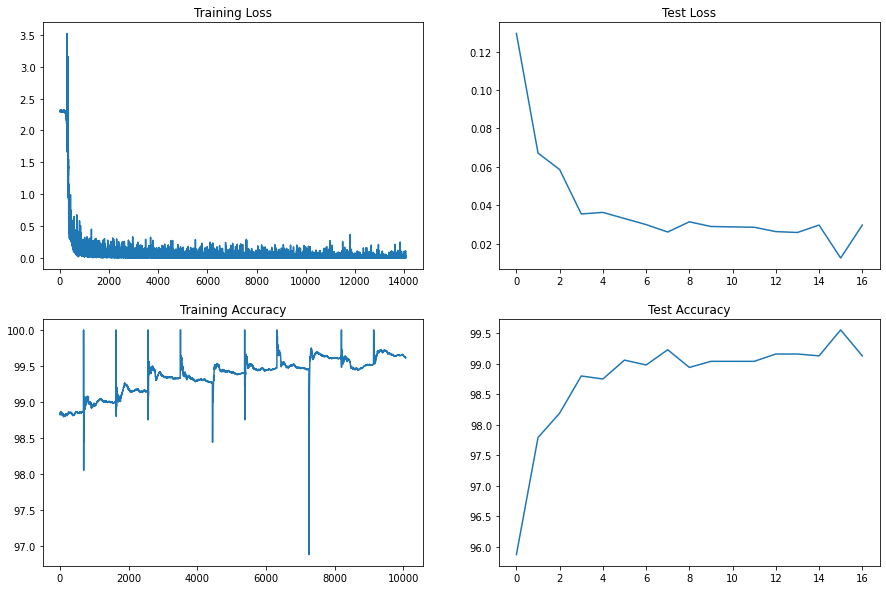

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")